Author : Richard A. Wolf  
Last update : April 2024  
Sources : this notebook is based on [Craig Gidney's "getting started" notebook](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) introducing the [Stim library](https://github.com/quantumlib/Stim)

In [1]:
import pymatching
import stim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NB_SHOTS = 100_000

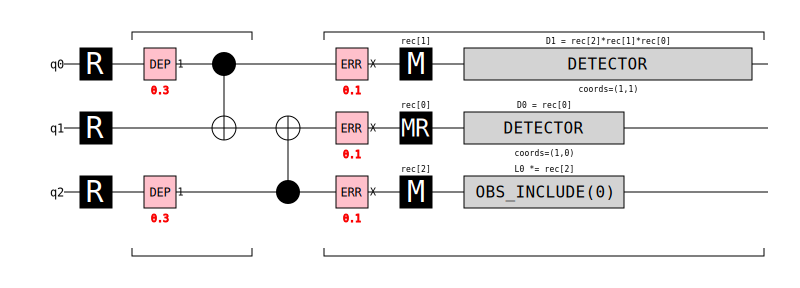

In [4]:
def make_repetition_code(depolarisation_proba:float=0.0, flip_proba:float=0.0) -> stim.Circuit:
    """Creates a quantum repetition code circuit."""
    code = stim.Circuit()

    for qb in range(3):
        code.append("R", [qb])

    ############################## Tick start
    code.append("TICK")

    code.append_operation("DEPOLARIZE1", 0, depolarisation_proba)
    code.append_operation("DEPOLARIZE1", 2, depolarisation_proba)

    code.append("CNOT", [0, 1])

    code.append("TICK")
    ############################## Tick end

    code.append("CNOT", [2, 1])

    ############################## Tick start
    code.append("TICK")

    for qb in range(3):
        code.append("X_ERROR", qb, flip_proba)
        
    code.append("MR", [1])
    code.append("M", [0, 2])
    
    code.append("DETECTOR", [stim.target_rec(-3)], [1,0])
    code.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)
    code.append("DETECTOR", [ stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3)], [1,1])
    
    code.append("TICK")
    ############################## Tick end

    return code

code = make_repetition_code(0.3, 0.1)
code.diagram('timeline-svg')

In [5]:
def benchmark_decoder_perf(depolarisation_proba:float=0.0, flip_proba:float=0.0, nb_shots:int=100_000):

    # Create a circuit
    code_circuit = make_repetition_code(depolarisation_proba=depolarisation_proba, flip_proba=flip_proba)
    
    # Create a detector sampler
    detector_sampler = code_circuit.compile_detector_sampler()
    detection_events, observable_flips = detector_sampler.sample(nb_shots, separate_observables=True)

    # Generate a detector error model
    detector_error_model = code_circuit.detector_error_model(decompose_errors=True)

    # Create a PyMatching decoder based on the detector error model
    decoder = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Use the decoder
    predictions = decoder.decode_batch(detection_events)

    # Count the number of times the decoder failed
    nb_logical_errors = sum(bool(x) != y for x, y in zip(predictions, observable_flips))

    return (nb_logical_errors[0] / nb_shots) * 100

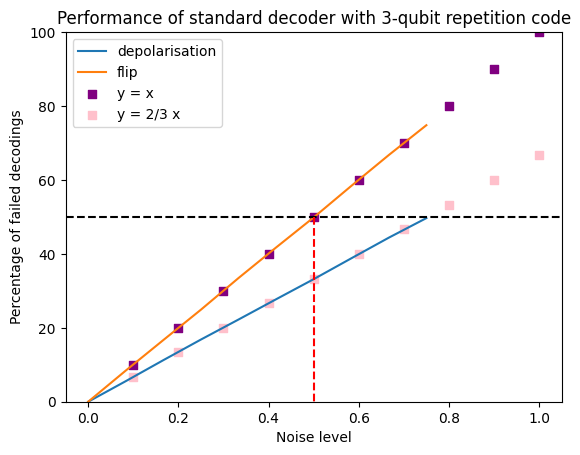

In [6]:
MAX_NOISE_ALLOWED = 3/4

noise_levels = np.linspace(0,MAX_NOISE_ALLOWED,10)

our_decoder_perfs_depolarisation = [benchmark_decoder_perf(depolarisation_proba=p) for p in noise_levels]

our_decoder_perfs_flip = [benchmark_decoder_perf(flip_proba=p) for p in noise_levels]


plt.plot(noise_levels, our_decoder_perfs_depolarisation, label="depolarisation")
plt.plot(noise_levels, our_decoder_perfs_flip, label="flip")
plt.title("Performance of standard decoder with 3-qubit repetition code")
plt.xlabel("Noise level")
plt.ylabel("Percentage of failed decodings")
plt.ylim(0,100)
plt.axhline(y=50, color='black', linestyle='--')


# Draw a red line down to x-axis when depolarisation performance crosses the coin-flip line
for i in range(len(noise_levels) - 1):
    x1, x2 = noise_levels[i], noise_levels[i+1]
    y1, y2 = our_decoder_perfs_flip[i], our_decoder_perfs_flip[i+1]
    if y1 <= 50 <= y2 or y2 <= 50 <= y1:
        m = (y2 - y1) / (x2 - x1)
        x_intersect = x1 + (50 - y1) / m
        plt.plot([x_intersect, x_intersect], [50, 0], 'r--')
        break

coordinates = [(i * 0.1, i * 10) for i in range(1, 11)]
x_values, y_values = zip(*coordinates)
plt.scatter(x_values, y_values, color='purple', marker='s', label="y = x")

coordinates = [(i * 0.1, i * 10 / 3 * 2) for i in range(1, 11)]
x_values, y_values = zip(*coordinates)
plt.scatter(x_values, y_values, color='pink', marker='s', label="y = 2/3 x")

plt.title("Performance of standard decoder with 3-qubit repetition code")
plt.xlabel("Noise level")
plt.ylabel("Percentage of failed decodings")
plt.legend()
plt.show()